# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

PermissionError: [Errno 13] Permission denied: '/input'

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

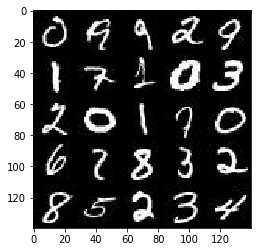

In [3]:

import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

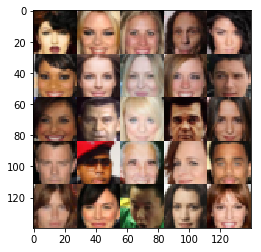

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.5
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                 labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                       labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #from IPython.core.debugger import Tracer; Tracer()()
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    #from IPython.core.debugger import Tracer; Tracer()()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.9791... Generator Loss: 0.0917
Epoch 1/2... Discriminator Loss: 3.0260... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 2.1211... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 2.0190... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.3659
Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 1.2621
Epoch 1/2... Discriminator Loss: 1.8399... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 2.1831... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 1.7050


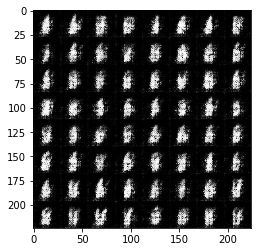

Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 1.5220
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.9815
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 2.4717
Epoch 1/2... Discriminator Loss: 1.6361... Generator Loss: 1.1309
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 1.3767
Epoch 1/2... Discriminator Loss: 1.5499... Generator Loss: 1.7896
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 1.1012
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 1.0568


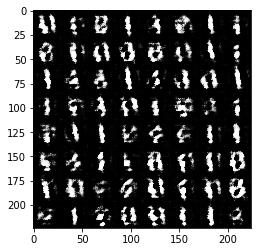

Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 1.5087
Epoch 1/2... Discriminator Loss: 1.4450... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.9025
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 1.5267... Generator Loss: 1.2957


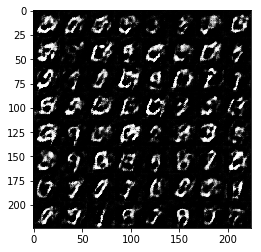

Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 1.0922
Epoch 1/2... Discriminator Loss: 1.5746... Generator Loss: 0.5880
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.6411... Generator Loss: 2.0403
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.9427


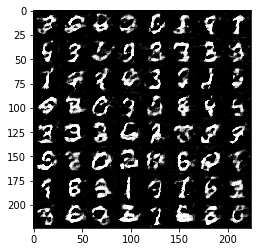

Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 1.3615
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 1.0343
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 1.4992... Generator Loss: 1.1778
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.5065... Generator Loss: 0.7686


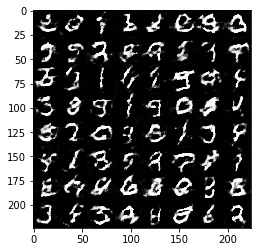

Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 1.5967
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 1.2520
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 1.1555
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.9978
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 1.1225


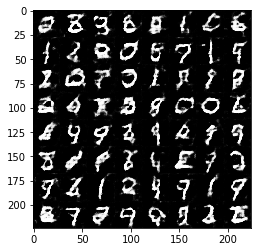

Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 1.2845
Epoch 1/2... Discriminator Loss: 1.2627... Generator Loss: 1.2253
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 1.4798
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.4361
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.0655


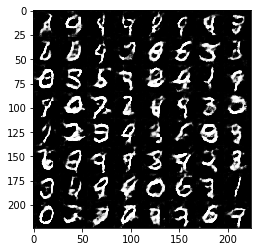

Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.8966
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 1.3440


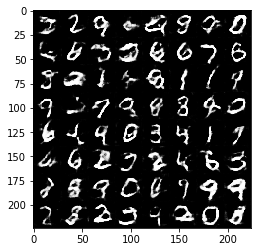

Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 1.2634
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 1.0366
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 0.7505
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.0517
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 1.3934


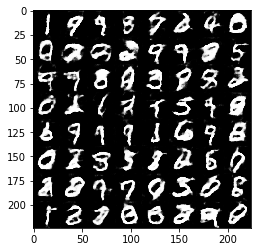

Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 1.0170
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 1.3358
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 3.0545... Generator Loss: 3.0116
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 1.0807


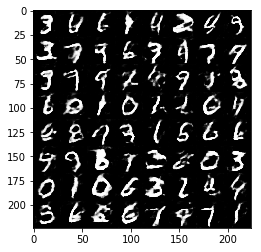

Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.1028
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 1.1628
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.4323
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 1.6115
Epoch 2/2... Discriminator Loss: 1.0489... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 1.2675
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.3519


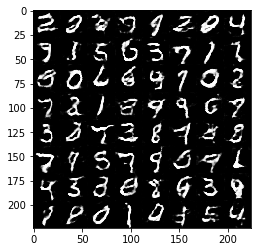

Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 1.1552
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 1.8520
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 1.2779
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.1877... Generator Loss: 1.9025
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 1.1177


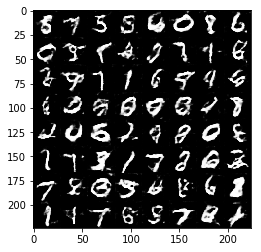

Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 1.7177
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.1166
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 1.3182
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.3322
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.6318
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.2725


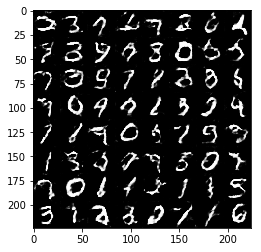

Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.6894
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.2997
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 1.5448
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 1.4932
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 1.8156
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.5071
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 1.6290


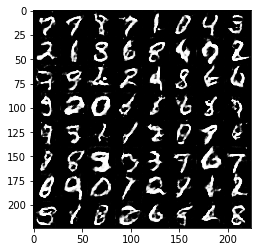

Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 1.4055
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 1.7714
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 1.9630
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.5959
Epoch 2/2... Discriminator Loss: 1.7156... Generator Loss: 0.3478
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.6056
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 2.2415


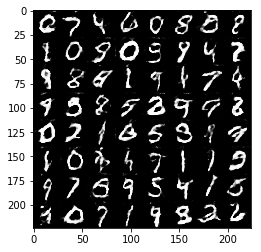

Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.7526
Epoch 2/2... Discriminator Loss: 1.9851... Generator Loss: 0.3123
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 2.2612
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 1.0966
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 2.0372
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 1.3103


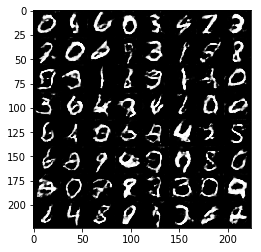

Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.5660
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.9305
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.9315
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 1.4500... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 1.1676
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.9988
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 2.2962
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.2879


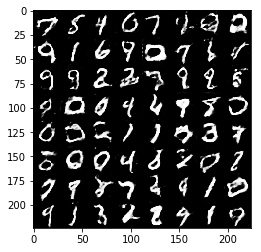

Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 2.1343
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 1.7119
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 0.8239... Generator Loss: 1.4662
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.6688
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 2.8635
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.7065


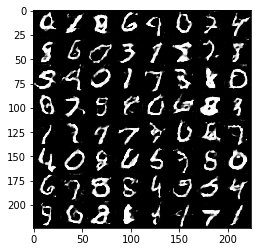

Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.8020
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.5929
Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.7187
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 3.0552
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 2.0017


IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#from IPython.core.debugger import Tracer; Tracer()()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.